In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np  # noqa
import pandas as pd


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3824 entries, 2010-01-11 to 2025-04-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   3824 non-null   float64
dtypes: float64(1)
memory usage: 59.8 KB


<Axes: xlabel='date'>

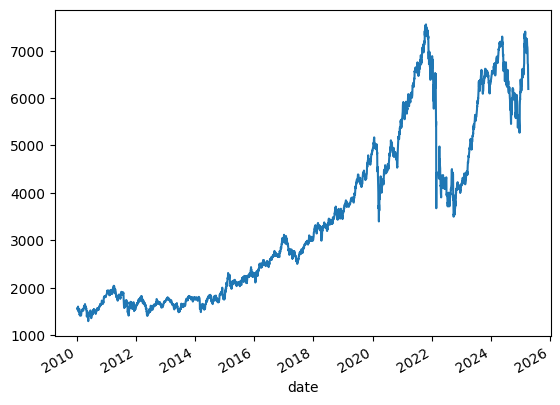

In [11]:
mcftrr = pd.read_excel("../data/endog_data/mcftrr.xlsx", sheet_name="Sheet1")
mcftrr["date"] = pd.to_datetime(mcftrr["date"])
mcftrr.set_index("date", inplace=True)

mcftrr.info()
mcftrr["price"].plot()


# Marcos Lopes De Prado paper

### CUSUM filter

In [12]:
# cusum filter
def extract_cusum_events(stock_price: pd.Series, h: float) -> pd.DatetimeIndex:
    """
    Реализует CUSUM-фильтр для обнаружения значительных изменений в ценовом ряду.
    Фиксирует моменты, когда кумулятивные положительные/отрицательные изменения превышают порог `h`.

    Parameters
    ----------
    stock_price : pd.Series
        Временной ряд цен актива с датами в индексе.
    h : float
        Порог для триггера событий.
        Пример: h=10 фиксирует события при накоплении изменений >10 (в абсолютных значениях) от исходной цены.

    Returns
    -------
    pd.DatetimeIndex
        Даты событий, когда были превышены пороговые значения.
    """
    dt_events, s_pos, s_neg = [], 0, 0
    stock_price_diff = stock_price.diff()

    for dt_index, cur_diff in zip(
        stock_price_diff.index[1:], stock_price_diff[1:].to_numpy()
    ):
        s_pos = max(0, s_pos + cur_diff)
        s_neg = min(0, s_neg + cur_diff)

        if s_neg < -h:
            s_neg = 0
            dt_events.append(dt_index)

        elif s_pos > h:
            s_pos = 0
            dt_events.append(dt_index)

    return pd.DatetimeIndex(dt_events)


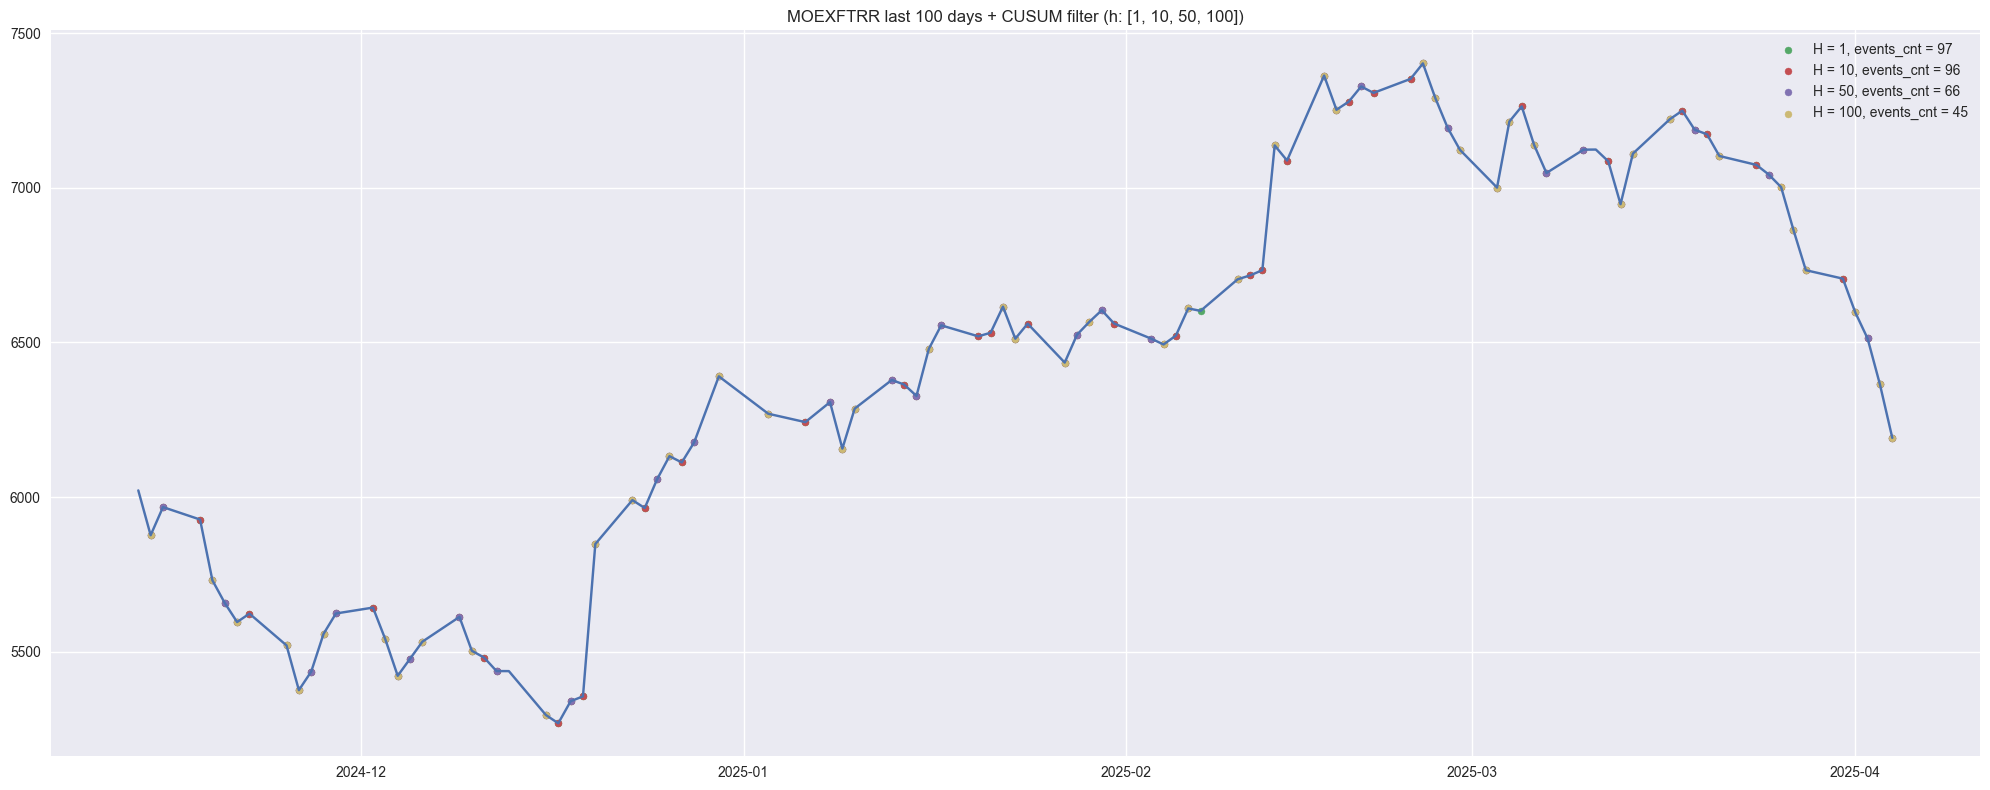

In [42]:
H_VALUES = [1, 10, 50, 100]
LAST_N_DAYS = 100
mpl.style.use("seaborn-v0_8")
fig, axes = plt.subplots(
    figsize=(20, 8),
)

mcftrr_tmp = mcftrr.tail(LAST_N_DAYS)
axes.set_title(f"MOEXFTRR last {LAST_N_DAYS} days + CUSUM filter (h: {H_VALUES})")
axes.plot(mcftrr_tmp.index, mcftrr_tmp.values)

for h_i, h in enumerate(H_VALUES):
    h_events = extract_cusum_events(mcftrr_tmp, h=h)
    axes.scatter(
        h_events,
        mcftrr_tmp.loc[h_events],
        s=25,
        color=f"C{h_i + 1}",
        label=f"H = {h}, events_cnt = {h_events.shape[0]}",
    )

axes.legend()
plt.tight_layout()
plt.show()


# Triple Barrier Method

In [4]:
def calculate_barriers(
    stock_price: pd.Series, shift_days: int = 10, vol_span: int = 10, c: int = 1
) -> pd.DataFrame:
    """
    Рассчитывает динамические ценовые барьеры (верхний, нижний и вертикальный) для торговой стратегии.
    Использует историческую волатильность для построения канала вокруг текущей цены.

    Parameters
    ----------
    stock_price : pd.Series
        Временной ряд цен актива с датами в индексе.
    shift_days : int, optional (default=10)
        Количество дней для расчета исторической доходности.
    vol_span : int, optional (default=10)
        Период сглаживания волатильности (экспоненциальное скользящее окно).
    c : int, optional (default=1)
        Множитель волатильности для определения ширины канала.

    Returns
    -------
    pd.DataFrame
        DataFrame с колонками:
        - price: исходная цена
        - shift: цена shift_days дней назад
        - vol_std: сглаженная волатильность
        - upper_barrier_price: верхний барьер (цена * exp(c * vol_std))
        - lower_barrier_price: нижний барьер (цена * exp(-c * vol_std))
        - vertical_barrier_ts: временной барьер (текущая дата + shift_days)

    Алгоритм:
    1. Рассчитывает логарифмическую доходность за shift_days дней
    2. Сглаживает волатильность через EWMA
    3. Строит барьеры на основе волатильности и коэффициента c
    4. Добавляет вертикальный барьер времени
    """
    # Создание рабочего DataFrame
    stock_price_df = pd.DataFrame(stock_price).reset_index()
    stock_price_df.columns = ["date", "price"]

    # Расчет исторической цены
    stock_price_df["shift"] = stock_price_df["price"].shift(shift_days)

    # Логарифмическая доходность и волатильность
    log_returns = np.log(stock_price_df["price"] / stock_price_df["shift"])
    stock_price_df["vol_std"] = log_returns.ewm(span=vol_span).std()

    # Ценовые барьеры
    stock_price_df["upper_barrier_price"] = stock_price_df["price"] * np.exp(
        c * stock_price_df["vol_std"]
    )
    stock_price_df["lower_barrier_price"] = stock_price_df["price"] * np.exp(
        -c * stock_price_df["vol_std"]
    )

    # Вертикальный временной барьер
    stock_price_df["vertical_barrier_ts"] = stock_price_df["date"].shift(-shift_days)

    # Восстановление индекса
    stock_price_df.set_index("date", inplace=True)

    return stock_price_df


barriers_df = calculate_barriers(stock_price=mcftrr, shift_days=10, vol_span=50, c=10)
barriers_df.info()
barriers_df.head(50)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3824 entries, 2010-01-11 to 2025-04-04
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   price                3824 non-null   float64       
 1   shift                3814 non-null   float64       
 2   vol_std              3813 non-null   float64       
 3   upper_barrier_price  3813 non-null   float64       
 4   lower_barrier_price  3813 non-null   float64       
 5   vertical_barrier_ts  3814 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 209.1 KB


,price,shift,vol_std,upper_barrier_price,lower_barrier_price,vertical_barrier_ts
date,,,,,,
2010-01-11,1556.58,NaN,NaN,NaN,NaN,2010-01-25
2010-01-12,1538.15,NaN,NaN,NaN,NaN,2010-01-26
2010-01-13,1546.06,NaN,NaN,NaN,NaN,2010-01-27
2010-01-14,1568.29,NaN,NaN,NaN,NaN,2010-01-28
2010-01-15,1565.08,NaN,NaN,NaN,NaN,2010-01-29
2010-01-18,1594.02,NaN,NaN,NaN,NaN,2010-02-01
2010-01-19,1598.87,NaN,NaN,NaN,NaN,2010-02-02
2010-01-20,1574.31,NaN,NaN,NaN,NaN,2010-02-03
2010-01-21,1547.01,NaN,NaN,NaN,NaN,2010-02-04


In [25]:
import typing as t


def get_labels_from_barriers(
    barriers_df: pd.DataFrame, events: t.Optional[pd.DatetimeIndex] = None
) -> pd.Series:
    """
    Генерирует бинарные метки (1/-1) на основе пересечения ценовых барьеров.
    Метки определяют, достигла ли цена верхнего/нижнего барьера раньше вертикального временного предела.

    Parameters
    ----------
    barriers_df : pd.DataFrame
        DataFrame с барьерами, содержащий колонки:
        - price: исходная цена
        - upper_barrier_price: верхний ценовой барьер
        - lower_barrier_price: нижний ценовой барьер
        - vertical_barrier_ts: временной барьер (дата окончания окна)
    events : pd.DatetimeIndex, optional
        Даты событий для анализа. Если не указано, используются все данные.

    Returns
    -------
    pd.Series
        Метки:
        - 1: цена достигла верхнего барьера ИЛИ выросла к моменту вертикального барьера
        - -1: цена достигла нижнего барьера ИЛИ упала к моменту вертикального барьера
    """
    barriers_df = barriers_df.copy(deep=True)
    labels = []
    labels_index = []
    first_barrier_touch_times = []

    # Определяем набор данных для обработки
    processing_data = barriers_df.loc[events] if events is not None else barriers_df

    for index, row in processing_data.iterrows():
        # Проверка наличия вертикального барьера
        if pd.isna(row["vertical_barrier_ts"]):
            continue

        vertical_barrier = row["vertical_barrier_ts"]

        # Проверка существования вертикального барьера в индексе
        if vertical_barrier not in barriers_df.index:
            continue

        # Получение ценового окна из исходного DataFrame
        try:
            prices = barriers_df.loc[index:vertical_barrier].price
        except KeyError:
            continue

        # Поиск первого касания барьеров
        upper_touch = prices[prices > row["upper_barrier_price"]].index.min()
        lower_touch = prices[prices < row["lower_barrier_price"]].index.min()

        # Определение самого раннего события
        candidates = [upper_touch, lower_touch, vertical_barrier]
        valid_candidates = [
            x for x in candidates if x is not None and x in barriers_df.index
        ]

        if not valid_candidates:
            continue

        first_touch = min(valid_candidates)
        first_barrier_touch_times.append(first_touch)
        labels_index.append(index)

    # Генерация меток
    for start, end in zip(labels_index, first_barrier_touch_times):
        try:
            start_price = barriers_df.at[start, "price"]
            end_price = barriers_df.at[end, "price"]
            label = 1 if end_price > start_price else -1
            labels.append(label)
        except KeyError:
            continue

    return pd.Series(index=pd.DatetimeIndex(labels_index), data=labels, name="label")


labels = get_labels_from_barriers(barriers_df)
labels


2021-04-05    1
2021-04-06    1
2021-04-07    1
2021-04-08    1
2021-04-09    1
             ..
2025-03-17   -1
2025-03-18   -1
2025-03-19   -1
2025-03-20   -1
2025-03-21   -1
Name: label, Length: 990, dtype: int64

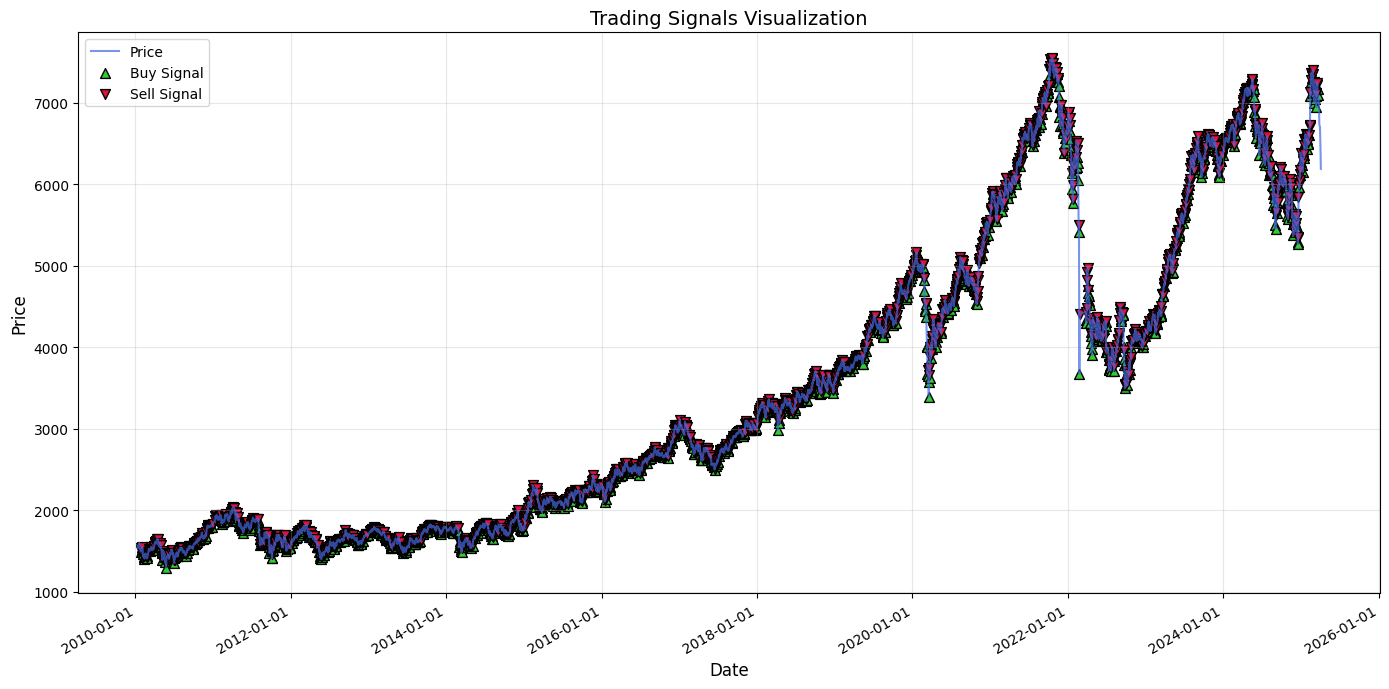

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def plot_labels(barriers_df: pd.DataFrame, labels: pd.Series) -> None:
    """
    Визуализирует ценовой ряд с метками покупки/продажи.

    Parameters
    ----------
    barriers_df : pd.DataFrame
        DataFrame с колонкой 'price'
    labels : pd.Series
        Метки с индексом типа DatetimeIndex
    """
    plt.figure(figsize=(14, 7))

    # # Рисуем ценовой ряд
    plt.plot(
        barriers_df.index,
        barriers_df["price"],
        label="Price",
        color="royalblue",
        alpha=0.7,
    )

    # Фильтруем метки
    buy_signals = labels[labels == 1]
    sell_signals = labels[labels == -1]

    # fig = go.Figure()
    # fig.add_trace(go.Scatter(x=barriers_df.index, y=barriers_df['price'], name='Price'))
    # fig.add_trace(go.Scatter(x=buy_signals.index, y=barriers_df.loc[buy_signals.index, 'price'],
    #                         mode='markers', name='Buy', marker=dict(color='green', size=10)))
    # fig.add_trace(go.Scatter(x=sell_signals.index, y=barriers_df.loc[sell_signals.index, 'price'],
    #                         mode='markers', name='Sell', marker=dict(color='red', size=10)))
    # fig.show()

    # Рисуем точки покупки/продажи
    plt.scatter(
        buy_signals.index,
        barriers_df.loc[buy_signals.index, "price"],
        color="limegreen",
        s=50,
        label="Buy Signal",
        marker="^",
        edgecolor="black",
    )
    plt.scatter(
        sell_signals.index,
        barriers_df.loc[sell_signals.index, "price"],
        color="crimson",
        s=50,
        label="Sell Signal",
        marker="v",
        edgecolor="black",
    )

    # Настройки графика
    plt.title("Trading Signals Visualization", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.grid(alpha=0.3)

    # Форматирование дат
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()

    # Легенда
    plt.legend()

    plt.tight_layout()
    plt.show()


# Пример использования
plot_labels(barriers_df, labels)


Filterred events: now we have 288 events from 1000 dt-points


,price,shift,vol_std,upper_barrier_price,lower_barrier_price,vertical_barrier_ts
date,,,,,,
2021-04-05,5973.85,NaN,NaN,NaN,NaN,2021-04-19
2021-04-06,5921.25,NaN,NaN,NaN,NaN,2021-04-20
2021-04-07,5932.18,NaN,NaN,NaN,NaN,2021-04-21
2021-04-08,5944.87,NaN,NaN,NaN,NaN,2021-04-22
2021-04-09,5907.92,NaN,NaN,NaN,NaN,2021-04-23
2021-04-12,5969.98,NaN,NaN,NaN,NaN,2021-04-26
2021-04-13,5976.17,NaN,NaN,NaN,NaN,2021-04-27
2021-04-14,6061.91,NaN,NaN,NaN,NaN,2021-04-28
2021-04-15,6047.71,NaN,NaN,NaN,NaN,2021-04-29


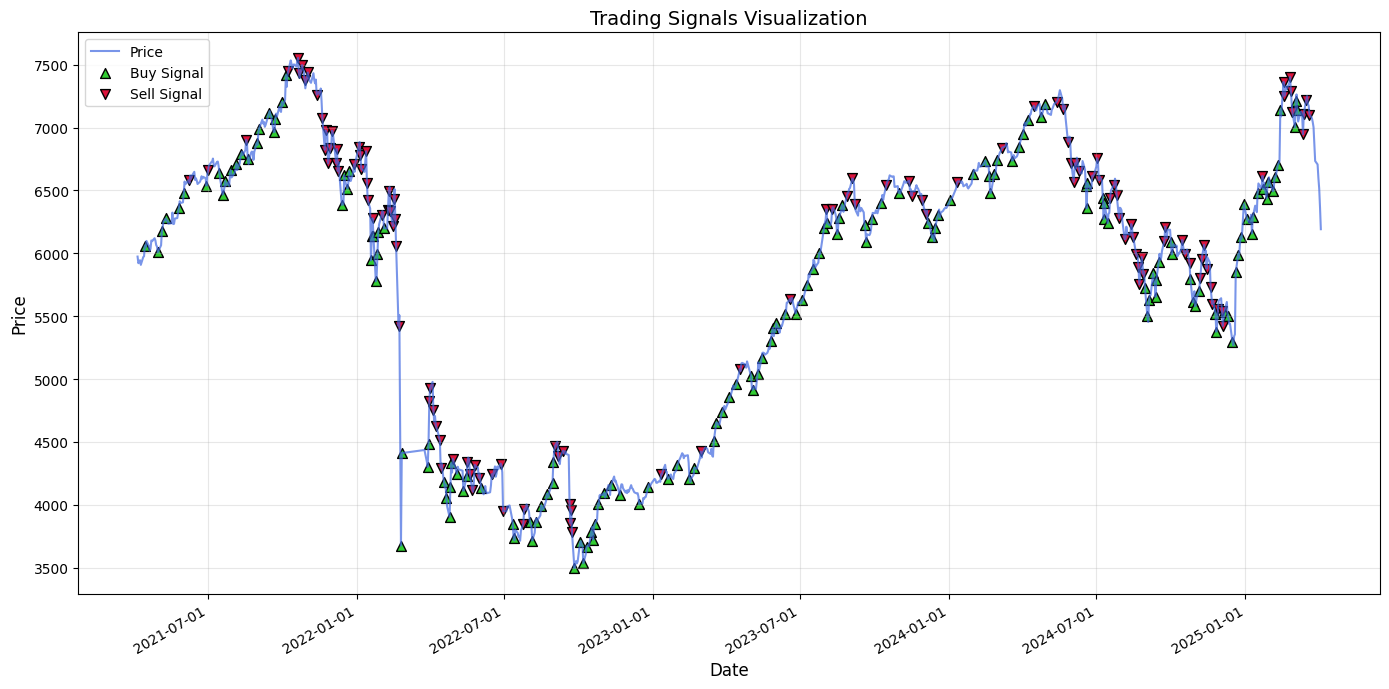

In [28]:
# попробуем добавить фильтр на события и возьмем только последние 1000 дней
LAST_N_DAYS = 1000

mcftrr_tmp = mcftrr.tail(LAST_N_DAYS).copy(deep=True)
events = extract_cusum_events(mcftrr_tmp, h=100)
print(
    f"Filterred events: now we have {events.shape[0]} events from {mcftrr_tmp.shape[0]} dt-points"
)

barriers_df = calculate_barriers(mcftrr_tmp, shift_days=10, vol_span=10, c=30)
display(barriers_df.head(50))

labels = get_labels_from_barriers(barriers_df, events)

plot_labels(barriers_df, labels)


In [ ]:
class TargetMarkup:
    def __init__(self, shift_days: int = 10, volatility_span: int = 10, barrier_constant: int = 2, use_cusum: bool = True, cusum_h: int = 100):
        pass

    def 


In [ ]:
C = 1
SHIFT_DAYS = 10

mcftrr_tmp = mcftrr.copy(deep=True).reset_index()
display(mcftrr_tmp)

mcftrr_tmp["Close_shift"] = mcftrr_tmp.price.shift(SHIFT_DAYS)
mcftrr_tmp["Vertical_Barrier_TS"] = mcftrr_tmp.date.shift(-SHIFT_DAYS)
mcftrr_tmp["std"] = (
    np.log(mcftrr_tmp["price"] / mcftrr_tmp["Close_shift"])
    .ewm(100, min_periods=100)
    .std()
)
mcftrr_tmp["Upper_Barrier"] = mcftrr_tmp["price"] * np.exp(C * mcftrr_tmp["std"])
mcftrr_tmp["Lower_Barrier"] = mcftrr_tmp["price"] * np.exp(-C * mcftrr_tmp["std"])
mcftrr_tmp


,date,price
0,2010-01-11,1556.58
1,2010-01-12,1538.15
2,2010-01-13,1546.06
3,2010-01-14,1568.29
4,2010-01-15,1565.08
...,...,...
3819,2025-03-31,6706.49
3820,2025-04-01,6597.59
3821,2025-04-02,6512.93
3822,2025-04-03,6364.24


,date,price,Close_shift,Vertical_Barrier_TS,std,Upper_Barrier,Lower_Barrier
0,2010-01-11,1556.58,NaN,2010-01-25,NaN,NaN,NaN
1,2010-01-12,1538.15,NaN,2010-01-26,NaN,NaN,NaN
2,2010-01-13,1546.06,NaN,2010-01-27,NaN,NaN,NaN
3,2010-01-14,1568.29,NaN,2010-01-28,NaN,NaN,NaN
4,2010-01-15,1565.08,NaN,2010-01-29,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3819,2025-03-31,6706.49,7222.45,NaT,0.053536,7075.315202,6356.891084
3820,2025-04-01,6597.59,7249.82,NaT,0.054253,6965.417653,6249.186478
3821,2025-04-02,6512.93,7188.17,NaT,0.055017,6881.290981,6164.287675
3822,2025-04-03,6364.24,7173.37,NaT,0.056174,6731.974707,6016.592834


In [ ]:
import typing as t


def get_labels(df: pd.DataFrame, events: t.Optional[pd.DatetimeIndex] = None):
    df = df.copy(deep=True)
    if events:
        df = df.loc[events]
    df.set_index("date", inplace=True)
    first_barrier_touch_times = []
    for index, row in df.iterrows():
        vertical_barrier = row["Vertical_Barrier_TS"]
        prices = df.loc[index:vertical_barrier].price
        upper_barrier_first_touch = prices[prices > row["Upper_Barrier"]].index.min()
        lower_barrier_first_touch = prices[prices < row["Lower_Barrier"]].index.min()
        first_barrier_touch_time = pd.Series(
            [upper_barrier_first_touch, lower_barrier_first_touch, vertical_barrier]
        ).min()
        first_barrier_touch_times.append(first_barrier_touch_time)

    if events:
        labels = [
            1 if df.price[end].min() > df.price[start].min() else -1
            for start, end in zip(events, first_barrier_touch_times)
        ]
    else:
        labels = [
            1 if df.price[end].min() > df.price[start].min() else -1
            for start, end in zip(df.dropna().index, first_barrier_touch_times)
        ]
    return labels


get_labels(mcftrr_tmp)


[1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,


In [ ]:
def triple_barrier_method(
    stock_price: pd.Series, events: pd.DataFrame, take_profit_stop_loss: np.ndarray, 
):


array([0, 0, 1, 2, 3, 5, 5, 6, 7, 8])